# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
!pip install -U torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# установка подходящей версии torch

from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [3]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перезагрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

Found existing installation: Pillow 5.3.0
Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-5.3.0-cp39-cp39-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.19.3 requires pillow!=7.1.0,!=7.1.1,!=8.3.0,>=6.1.0, but you have pillow 5.3.0 which is incompatible.
matplotlib 3.7.1 requires pillow>=6.2.0, but you have pillow 5.3.0 which is incompatible.
imageio 2.25.1 requires pillow>=8.3.2, but you have pillow 5.3.0 which is incompatible.
fastai 2.7.12 requires pillow>6.0.0, but you have pillow 5.3.0 which is incompatible.
dopamine-rl 4.0.6 requires Pillow>=7.0.0, but you have pillow 5.3.0 which is incompatible.
bokeh 2.4.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.
5.3.0

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
!unzip -q /content/gdrive/MyDrive/simpsons/data/train/simpsons_dataset.zip -d train
!unzip -q /content/gdrive/MyDrive/simpsons/data/test/testset.zip -d test

In [7]:
!ls train

__MACOSX  simpsons_dataset


In [8]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Apr 15 14:46:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [9]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models, datasets
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

/usr/local/lib/python3.9/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [70]:
DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 224

# DEVICE = torch.device("cuda")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [40]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):        
        transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.CenterCrop(224),
            # transforms.RandomRotation(degrees=(-20, 20)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [15]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [71]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [48]:
# for simple cnn and resnet
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')

In [72]:
# for last training (trying overfitting)
train_val_labels = [path.parent.name for path in train_val_files]
train_dataset = SimpsonsDataset(train_val_files, mode='train')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

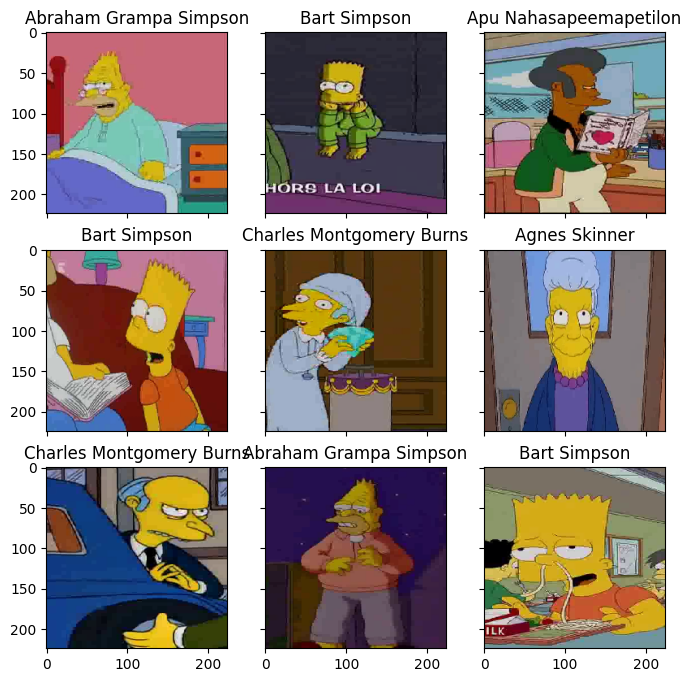

In [46]:
# for simple cnn and resnet
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
# for last training (trying overfitting)
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


опытным путем установила, что batchnorm2d лучше ставить после пуллинга!!!

In [49]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(128)
        )
        self.dropout = nn.Dropout(p=0.2)
        self.out = nn.Linear(128 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        logits = self.out(x)
        return logits

In [50]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [51]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [52]:
def train(train_files, val_files, model, epochs, optimizer, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    best_model_wts = model.state_dict()
    best_acc = 0.0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # lr didn't give me a better score :(
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model, history

In [53]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [54]:
n_classes = len(np.unique(train_val_labels))

In [55]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, paddi

In [56]:
# for simple cnn and resnet
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

Запустим обучение сети.

In [57]:
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=3e-4, betas=(0, 0.999), amsgrad=True)

In [58]:
model, history = train(train_dataset, val_dataset, model=simple_cnn, epochs=15, optimizer=optimizer, batch_size=64) 

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 2.0823161207161798


epoch:   7%|▋         | 1/15 [01:18<18:16, 78.29s/it]


Epoch 001 train_loss: 2.0823     val_loss 1.7218 train_acc 0.4584 val_acc 0.5340
loss 1.3208211534713832


epoch:  13%|█▎        | 2/15 [02:30<16:14, 74.96s/it]


Epoch 002 train_loss: 1.3208     val_loss 1.2741 train_acc 0.6423 val_acc 0.6563
loss 1.023531719486959


epoch:  20%|██        | 3/15 [03:51<15:30, 77.57s/it]


Epoch 003 train_loss: 1.0235     val_loss 1.0933 train_acc 0.7214 val_acc 0.7069
loss 0.817010630114123


epoch:  27%|██▋       | 4/15 [05:03<13:50, 75.53s/it]


Epoch 004 train_loss: 0.8170     val_loss 0.9838 train_acc 0.7754 val_acc 0.7319
loss 0.6634149442881457


epoch:  33%|███▎      | 5/15 [06:33<13:27, 80.71s/it]


Epoch 005 train_loss: 0.6634     val_loss 0.9463 train_acc 0.8187 val_acc 0.7451
loss 0.5530379722282244


epoch:  40%|████      | 6/15 [07:47<11:45, 78.36s/it]


Epoch 006 train_loss: 0.5530     val_loss 1.1337 train_acc 0.8495 val_acc 0.6893
loss 0.45623325694479816


epoch:  47%|████▋     | 7/15 [09:01<10:15, 76.91s/it]


Epoch 007 train_loss: 0.4562     val_loss 0.7395 train_acc 0.8787 val_acc 0.8084
loss 0.38981316621777845


epoch:  53%|█████▎    | 8/15 [10:14<08:49, 75.60s/it]


Epoch 008 train_loss: 0.3898     val_loss 0.7228 train_acc 0.8946 val_acc 0.8086
loss 0.3375710725501446


epoch:  60%|██████    | 9/15 [11:26<07:27, 74.61s/it]


Epoch 009 train_loss: 0.3376     val_loss 0.7197 train_acc 0.9094 val_acc 0.8126
loss 0.2848279648175991


epoch:  67%|██████▋   | 10/15 [12:38<06:09, 73.85s/it]


Epoch 010 train_loss: 0.2848     val_loss 0.6339 train_acc 0.9231 val_acc 0.8353
loss 0.24308865373624694


epoch:  73%|███████▎  | 11/15 [13:52<04:54, 73.60s/it]


Epoch 011 train_loss: 0.2431     val_loss 0.7759 train_acc 0.9380 val_acc 0.8013
loss 0.2121013463648332


epoch:  80%|████████  | 12/15 [15:04<03:39, 73.29s/it]


Epoch 012 train_loss: 0.2121     val_loss 0.5887 train_acc 0.9468 val_acc 0.8483
loss 0.1826338496573397


epoch:  87%|████████▋ | 13/15 [16:17<02:26, 73.15s/it]


Epoch 013 train_loss: 0.1826     val_loss 0.6061 train_acc 0.9538 val_acc 0.8477
loss 0.15564371835547416


epoch:  93%|█████████▎| 14/15 [17:31<01:13, 73.36s/it]


Epoch 014 train_loss: 0.1556     val_loss 0.5762 train_acc 0.9618 val_acc 0.8571
loss 0.13271616378121487


epoch: 100%|██████████| 15/15 [18:45<00:00, 75.00s/it]


Epoch 015 train_loss: 0.1327     val_loss 0.6174 train_acc 0.9683 val_acc 0.8437


Построим кривые обучения

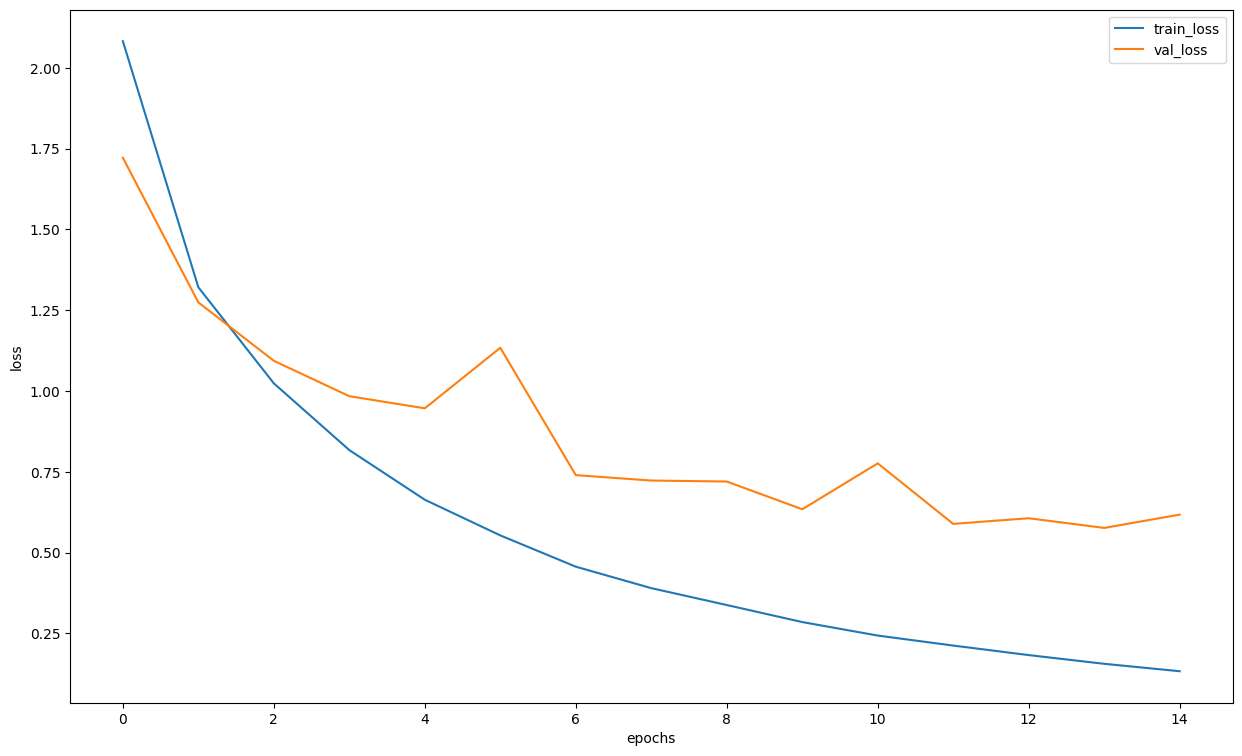

In [59]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

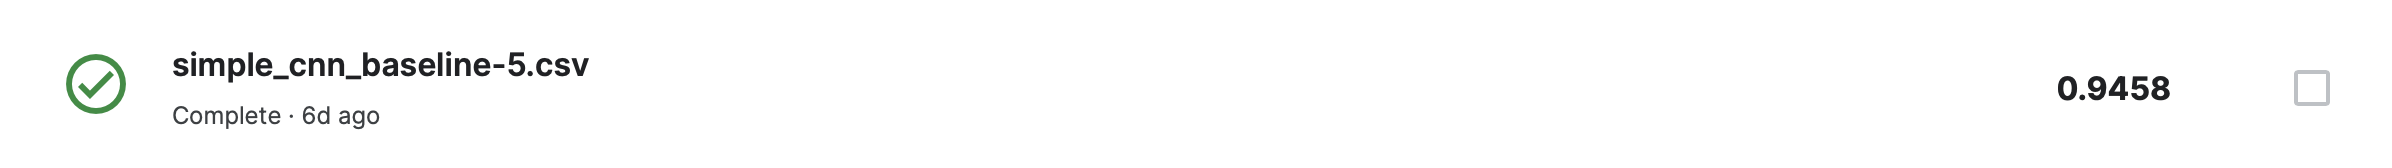

## Попробуем сеть ResNet

In [60]:
model_resnet18 = models.resnet18(pretrained=True).to(DEVICE)
print(model_resnet18)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 40.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
numb = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(numb, n_classes)
model_resnet18 = model_resnet18.to(DEVICE)

In [62]:
for name, param in model_resnet18.named_parameters():
    print(name, 'requires_grad:', param.requires_grad)

conv1.weight requires_grad: True
bn1.weight requires_grad: True
bn1.bias requires_grad: True
layer1.0.conv1.weight requires_grad: True
layer1.0.bn1.weight requires_grad: True
layer1.0.bn1.bias requires_grad: True
layer1.0.conv2.weight requires_grad: True
layer1.0.bn2.weight requires_grad: True
layer1.0.bn2.bias requires_grad: True
layer1.1.conv1.weight requires_grad: True
layer1.1.bn1.weight requires_grad: True
layer1.1.bn1.bias requires_grad: True
layer1.1.conv2.weight requires_grad: True
layer1.1.bn2.weight requires_grad: True
layer1.1.bn2.bias requires_grad: True
layer2.0.conv1.weight requires_grad: True
layer2.0.bn1.weight requires_grad: True
layer2.0.bn1.bias requires_grad: True
layer2.0.conv2.weight requires_grad: True
layer2.0.bn2.weight requires_grad: True
layer2.0.bn2.bias requires_grad: True
layer2.0.downsample.0.weight requires_grad: True
layer2.0.downsample.1.weight requires_grad: True
layer2.0.downsample.1.bias requires_grad: True
layer2.1.conv1.weight requires_grad: True


In [63]:
for name, param in model_resnet18.named_parameters():
    if name.startswith('layer4.1.') or name.startswith('fc.'):
        param.requires_grad = True
    else:
        param.requires_grad = False
    print(name, 'requires_grad:', param.requires_grad)

conv1.weight requires_grad: False
bn1.weight requires_grad: False
bn1.bias requires_grad: False
layer1.0.conv1.weight requires_grad: False
layer1.0.bn1.weight requires_grad: False
layer1.0.bn1.bias requires_grad: False
layer1.0.conv2.weight requires_grad: False
layer1.0.bn2.weight requires_grad: False
layer1.0.bn2.bias requires_grad: False
layer1.1.conv1.weight requires_grad: False
layer1.1.bn1.weight requires_grad: False
layer1.1.bn1.bias requires_grad: False
layer1.1.conv2.weight requires_grad: False
layer1.1.bn2.weight requires_grad: False
layer1.1.bn2.bias requires_grad: False
layer2.0.conv1.weight requires_grad: False
layer2.0.bn1.weight requires_grad: False
layer2.0.bn1.bias requires_grad: False
layer2.0.conv2.weight requires_grad: False
layer2.0.bn2.weight requires_grad: False
layer2.0.bn2.bias requires_grad: False
layer2.0.downsample.0.weight requires_grad: False
layer2.0.downsample.1.weight requires_grad: False
layer2.0.downsample.1.bias requires_grad: False
layer2.1.conv1.wei

In [64]:
optimizer = torch.optim.Adam((list(model_resnet18.parameters()))[-8:], lr=1e-3)

In [65]:
model, history = train(train_dataset, val_dataset, model=model_resnet18, epochs=15, optimizer=optimizer, batch_size=64)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.7427780243065473


epoch:   7%|▋         | 1/15 [01:20<18:44, 80.36s/it]


Epoch 001 train_loss: 0.7428     val_loss 0.4327 train_acc 0.8177 val_acc 0.8907
loss 0.24137445438955307


epoch:  13%|█▎        | 2/15 [02:41<17:27, 80.61s/it]


Epoch 002 train_loss: 0.2414     val_loss 0.3779 train_acc 0.9380 val_acc 0.9039
loss 0.11333776025572691


epoch:  20%|██        | 3/15 [04:02<16:08, 80.75s/it]


Epoch 003 train_loss: 0.1133     val_loss 0.3399 train_acc 0.9724 val_acc 0.9133
loss 0.05572790496551529


epoch:  27%|██▋       | 4/15 [05:23<14:50, 80.92s/it]


Epoch 004 train_loss: 0.0557     val_loss 0.3389 train_acc 0.9872 val_acc 0.9156
loss 0.037186569111560874


epoch:  33%|███▎      | 5/15 [06:45<13:34, 81.49s/it]


Epoch 005 train_loss: 0.0372     val_loss 0.3643 train_acc 0.9912 val_acc 0.9146
loss 0.027475440168447274


epoch:  40%|████      | 6/15 [08:11<12:25, 82.81s/it]


Epoch 006 train_loss: 0.0275     val_loss 0.3526 train_acc 0.9929 val_acc 0.9173
loss 0.018664873640976465


epoch:  47%|████▋     | 7/15 [09:36<11:08, 83.62s/it]


Epoch 007 train_loss: 0.0187     val_loss 0.3490 train_acc 0.9960 val_acc 0.9220
loss 0.01974108503031931


epoch:  53%|█████▎    | 8/15 [11:02<09:50, 84.34s/it]


Epoch 008 train_loss: 0.0197     val_loss 0.3843 train_acc 0.9954 val_acc 0.9161
loss 0.028751952163937985


epoch:  60%|██████    | 9/15 [12:27<08:28, 84.74s/it]


Epoch 009 train_loss: 0.0288     val_loss 0.4425 train_acc 0.9915 val_acc 0.9014
loss 0.03711808687362506


epoch:  67%|██████▋   | 10/15 [13:53<07:04, 84.89s/it]


Epoch 010 train_loss: 0.0371     val_loss 0.4325 train_acc 0.9899 val_acc 0.9071
loss 0.03836662374914767


epoch:  73%|███████▎  | 11/15 [15:15<05:36, 84.22s/it]


Epoch 011 train_loss: 0.0384     val_loss 0.4626 train_acc 0.9886 val_acc 0.8993
loss 0.03456833986709627


epoch:  80%|████████  | 12/15 [16:35<04:08, 82.94s/it]


Epoch 012 train_loss: 0.0346     val_loss 0.3873 train_acc 0.9904 val_acc 0.9182
loss 0.016418243892273976


epoch:  87%|████████▋ | 13/15 [17:54<02:43, 81.79s/it]


Epoch 013 train_loss: 0.0164     val_loss 0.3875 train_acc 0.9961 val_acc 0.9215
loss 0.009067264379737353


epoch:  93%|█████████▎| 14/15 [19:14<01:21, 81.18s/it]


Epoch 014 train_loss: 0.0091     val_loss 0.3946 train_acc 0.9971 val_acc 0.9230
loss 0.01435879195125828


epoch: 100%|██████████| 15/15 [20:34<00:00, 82.30s/it]


Epoch 015 train_loss: 0.0144     val_loss 0.4294 train_acc 0.9958 val_acc 0.9199


Построим кривые обучения

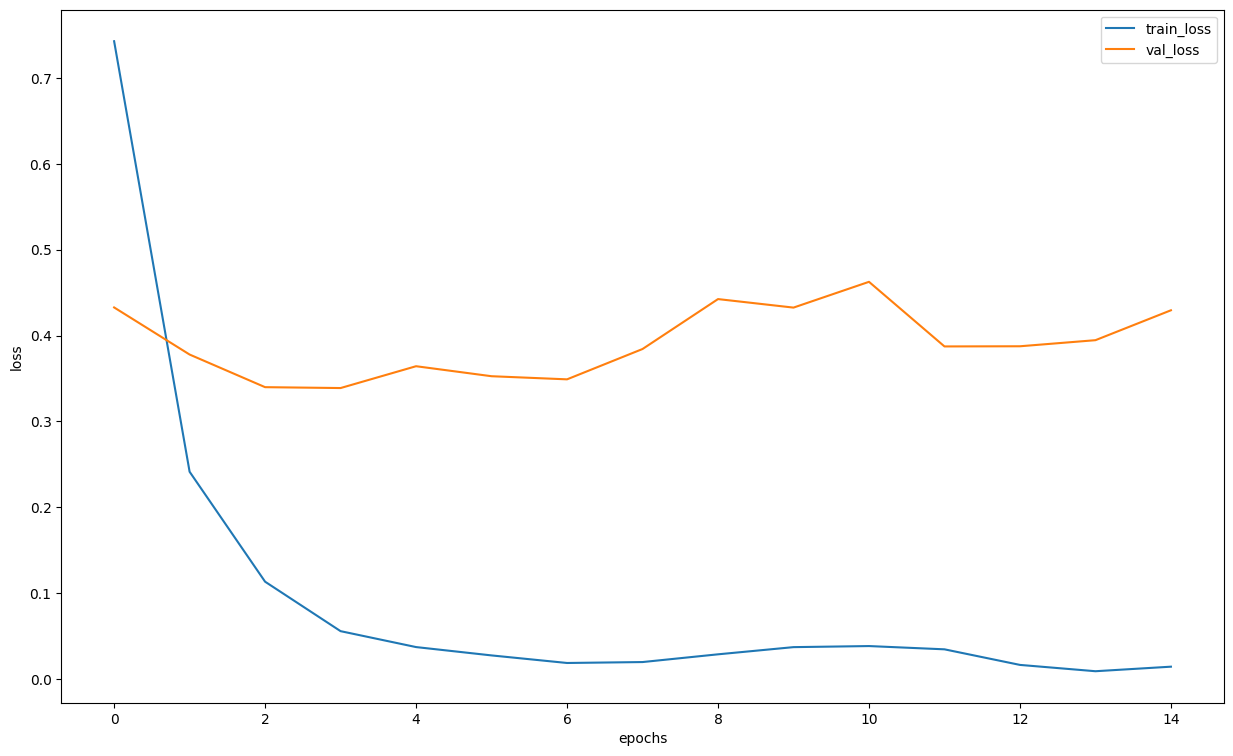

In [66]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

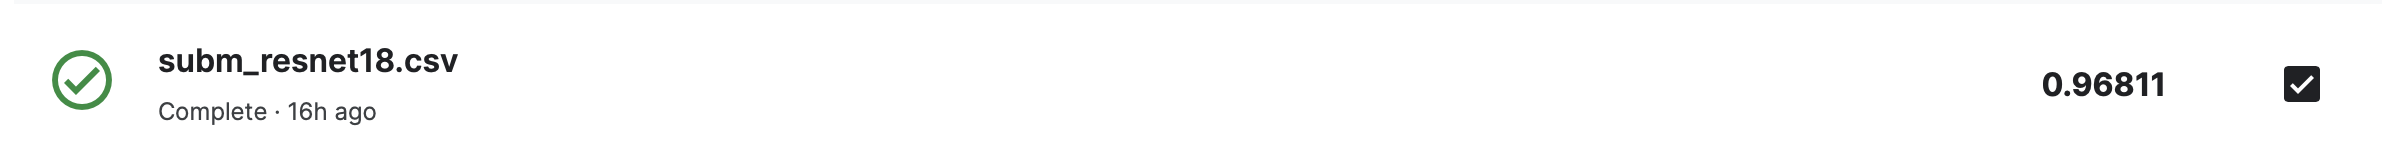

### Теперь попробуем обучить сетку только на train_dataset

(увидела в группе информацию о том, что обучение чисто на train дает наивысший скор на кагле)

In [73]:
def fit_epoch_new(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        scheduler.step() #added scheduler
        
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [74]:
def new_train(train_val_files, model, epochs, batch_size, optimizer, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"


    best_model_wts = model.state_dict()
    best_acc = 0.0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            optimizer = torch.optim.Adam((list(model.parameters()))[-8:], lr=1e-3)
            train_loss, train_acc = fit_epoch_new(model, train_loader, criterion, optimizer, scheduler)
            print("loss", train_loss)
            
            history.append((train_loss, train_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))

            if train_acc > best_acc:
                best_acc = train_acc
                best_model_wts = model.state_dict()
    model.load_state_dict(best_model_wts)
    return model, history

In [75]:
model_resnet18 = models.resnet18(pretrained=True).to(DEVICE)

numb = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(numb, n_classes)
model_resnet18 = model_resnet18.to(DEVICE)

for name, param in model_resnet18.named_parameters():
    if name.startswith('layer4.1.') or name.startswith('fc.'):
        param.requires_grad = True
    else:
        param.requires_grad = False
    print(name, 'requires_grad:', param.requires_grad)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv1.weight requires_grad: False
bn1.weight requires_grad: False
bn1.bias requires_grad: False
layer1.0.conv1.weight requires_grad: False
layer1.0.bn1.weight requires_grad: False
layer1.0.bn1.bias requires_grad: False
layer1.0.conv2.weight requires_grad: False
layer1.0.bn2.weight requires_grad: False
layer1.0.bn2.bias requires_grad: False
layer1.1.conv1.weight requires_grad: False
layer1.1.bn1.weight requires_grad: False
layer1.1.bn1.bias requires_grad: False
layer1.1.conv2.weight requires_grad: False
layer1.1.bn2.weight requires_grad: False
layer1.1.bn2.bias requires_grad: False
layer2.0.conv1.weight requires_grad: False
layer2.0.bn1.weight requires_grad: False
layer2.0.bn1.bias requires_grad: False
layer2.0.conv2.weight requires_grad: False
layer2.0.bn2.weight requires_grad: False
layer2.0.bn2.bias requires_grad: False
layer2.0.downsample.0.weight requires_grad: False
layer2.0.downsample.1.weight requires_grad: False
layer2.0.downsample.1.bias requires_grad: False
layer2.1.conv1.wei

In [76]:
optimizer = torch.optim.Adam((list(model_resnet18.parameters()))[-8:], lr=1e-3)

In [77]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [ ]:
model, history = new_train(train_dataset, model=model_resnet18, epochs=25, batch_size=64, optimizer=optimizer, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
epoch:   4%|▍         | 1/25 [01:33<37:21, 93.40s/it]

loss 0.6628776839907817

Epoch 001 train_loss: 0.6629 train_acc 0.8361


epoch:   8%|▊         | 2/25 [03:03<34:59, 91.27s/it]

loss 0.26137642606310535

Epoch 002 train_loss: 0.2614 train_acc 0.9287


epoch:  12%|█▏        | 3/25 [04:33<33:18, 90.86s/it]

loss 0.1463903532329795

Epoch 003 train_loss: 0.1464 train_acc 0.9601


epoch:  16%|█▌        | 4/25 [06:03<31:40, 90.50s/it]

loss 0.08653280583875825

Epoch 004 train_loss: 0.0865 train_acc 0.9756


epoch:  20%|██        | 5/25 [07:33<30:05, 90.25s/it]

loss 0.06216375398850983

Epoch 005 train_loss: 0.0622 train_acc 0.9814


epoch:  24%|██▍       | 6/25 [09:02<28:30, 90.04s/it]

loss 0.053524468850384636

Epoch 006 train_loss: 0.0535 train_acc 0.9846


epoch:  28%|██▊       | 7/25 [10:33<27:04, 90.26s/it]

loss 0.03930231051434358

Epoch 007 train_loss: 0.0393 train_acc 0.9873


epoch:  32%|███▏      | 8/25 [12:03<25:34, 90.26s/it]

loss 0.03909842516862645

Epoch 008 train_loss: 0.0391 train_acc 0.9893


epoch:  36%|███▌      | 9/25 [13:32<23:54, 89.64s/it]

loss 0.03268482493519734

Epoch 009 train_loss: 0.0327 train_acc 0.9904


epoch:  40%|████      | 10/25 [14:58<22:08, 88.57s/it]

loss 0.033209624572738065

Epoch 010 train_loss: 0.0332 train_acc 0.9897


epoch:  44%|████▍     | 11/25 [16:25<20:31, 87.97s/it]

loss 0.025525595572011096

Epoch 011 train_loss: 0.0255 train_acc 0.9926


epoch:  48%|████▊     | 12/25 [17:50<18:55, 87.35s/it]

loss 0.02351227315440927

Epoch 012 train_loss: 0.0235 train_acc 0.9932


epoch:  52%|█████▏    | 13/25 [19:18<17:29, 87.44s/it]

loss 0.022678233449823827

Epoch 013 train_loss: 0.0227 train_acc 0.9938


epoch:  56%|█████▌    | 14/25 [20:44<15:57, 87.09s/it]

loss 0.018378399823380395

Epoch 014 train_loss: 0.0184 train_acc 0.9945


epoch:  60%|██████    | 15/25 [22:11<14:28, 86.85s/it]

loss 0.024275635952683512

Epoch 015 train_loss: 0.0243 train_acc 0.9939


epoch:  64%|██████▍   | 16/25 [23:38<13:02, 87.00s/it]

loss 0.021145517855687065

Epoch 016 train_loss: 0.0211 train_acc 0.9929


epoch:  68%|██████▊   | 17/25 [25:05<11:35, 86.96s/it]

loss 0.01745989684797035

Epoch 017 train_loss: 0.0175 train_acc 0.9952


epoch:  72%|███████▏  | 18/25 [26:31<10:07, 86.77s/it]

loss 0.01431245800129607

Epoch 018 train_loss: 0.0143 train_acc 0.9961


epoch:  76%|███████▌  | 19/25 [27:57<08:38, 86.46s/it]

loss 0.014732943536891549

Epoch 019 train_loss: 0.0147 train_acc 0.9962


epoch:  80%|████████  | 20/25 [29:22<07:09, 85.99s/it]

loss 0.012678494796499505

Epoch 020 train_loss: 0.0127 train_acc 0.9959


epoch:  84%|████████▍ | 21/25 [30:48<05:43, 85.96s/it]

loss 0.013102459651995297

Epoch 021 train_loss: 0.0131 train_acc 0.9955


epoch:  88%|████████▊ | 22/25 [32:14<04:18, 86.10s/it]

loss 0.01208186797698984

Epoch 022 train_loss: 0.0121 train_acc 0.9966


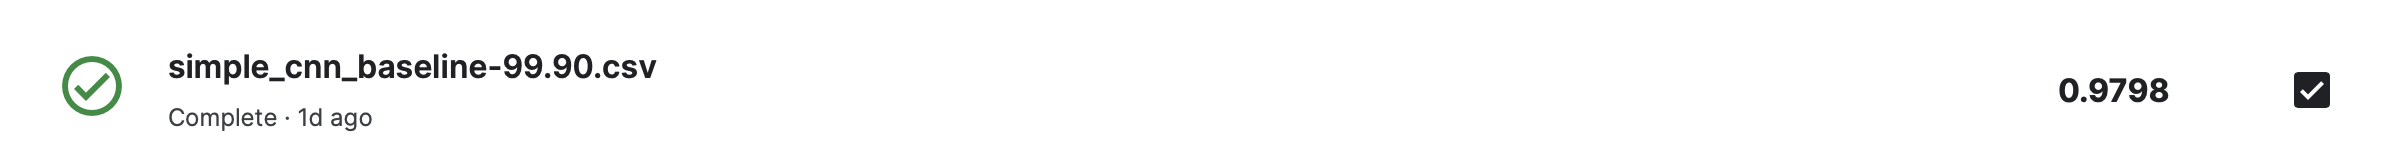

Построим кривую обучения

In [ ]:
loss, acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Теперь очередь Efficient Net

In [28]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=44de9ff72daea902d6bcff2026b28e440d7a4c84a893acb6dfc4bac0b84d85f3
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet_pytorch


In [29]:
from efficientnet_pytorch import EfficientNet
model_effnet = EfficientNet.from_pretrained('efficientnet-b2').to(DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 73.5MB/s]


Loaded pretrained weights for efficientnet-b2


In [30]:
model_effnet

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [31]:
for name, param in model_effnet.named_parameters():
    print(name, 'requires_grad:', param.requires_grad)

_conv_stem.weight requires_grad: True
_bn0.weight requires_grad: True
_bn0.bias requires_grad: True
_blocks.0._depthwise_conv.weight requires_grad: True
_blocks.0._bn1.weight requires_grad: True
_blocks.0._bn1.bias requires_grad: True
_blocks.0._se_reduce.weight requires_grad: True
_blocks.0._se_reduce.bias requires_grad: True
_blocks.0._se_expand.weight requires_grad: True
_blocks.0._se_expand.bias requires_grad: True
_blocks.0._project_conv.weight requires_grad: True
_blocks.0._bn2.weight requires_grad: True
_blocks.0._bn2.bias requires_grad: True
_blocks.1._depthwise_conv.weight requires_grad: True
_blocks.1._bn1.weight requires_grad: True
_blocks.1._bn1.bias requires_grad: True
_blocks.1._se_reduce.weight requires_grad: True
_blocks.1._se_reduce.bias requires_grad: True
_blocks.1._se_expand.weight requires_grad: True
_blocks.1._se_expand.bias requires_grad: True
_blocks.1._project_conv.weight requires_grad: True
_blocks.1._bn2.weight requires_grad: True
_blocks.1._bn2.bias requires

In [32]:
model_effnet._fc = nn.Linear(model_effnet._fc.in_features, n_classes)
model_effnet = model_effnet.to(DEVICE)

In [33]:
for name, param in model_effnet.named_parameters():
    if name.startswith('_fc.') or name.startswith('_conv_head.') or name.startswith('_bn1.'):
        param.requires_grad = True
    else:
        param.requires_grad = False
    print(name, 'requires_grad:', param.requires_grad)

_conv_stem.weight requires_grad: False
_bn0.weight requires_grad: False
_bn0.bias requires_grad: False
_blocks.0._depthwise_conv.weight requires_grad: False
_blocks.0._bn1.weight requires_grad: False
_blocks.0._bn1.bias requires_grad: False
_blocks.0._se_reduce.weight requires_grad: False
_blocks.0._se_reduce.bias requires_grad: False
_blocks.0._se_expand.weight requires_grad: False
_blocks.0._se_expand.bias requires_grad: False
_blocks.0._project_conv.weight requires_grad: False
_blocks.0._bn2.weight requires_grad: False
_blocks.0._bn2.bias requires_grad: False
_blocks.1._depthwise_conv.weight requires_grad: False
_blocks.1._bn1.weight requires_grad: False
_blocks.1._bn1.bias requires_grad: False
_blocks.1._se_reduce.weight requires_grad: False
_blocks.1._se_reduce.bias requires_grad: False
_blocks.1._se_expand.weight requires_grad: False
_blocks.1._se_expand.bias requires_grad: False
_blocks.1._project_conv.weight requires_grad: False
_blocks.1._bn2.weight requires_grad: False
_block

In [34]:
model=model_effnet

In [35]:
optimizer = torch.optim.Adam((list(model.parameters()))[-2:], lr=1e-3)

In [36]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.6)

In [44]:
# model, history = train(train_dataset, val_dataset, model=model, epochs=15, optimizer=optimizer, batch_size=64)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 1.4712708593402002


epoch:   7%|▋         | 1/15 [02:11<30:45, 131.80s/it]


Epoch 001 train_loss: 1.4713     val_loss 0.6819 train_acc 0.6603 val_acc 0.8259
loss 0.6557420301311327


epoch:  13%|█▎        | 2/15 [04:10<26:55, 124.27s/it]


Epoch 002 train_loss: 0.6557     val_loss 0.5128 train_acc 0.8299 val_acc 0.8659
loss 0.4813064693630072


epoch:  20%|██        | 3/15 [06:09<24:19, 121.61s/it]


Epoch 003 train_loss: 0.4813     val_loss 0.4491 train_acc 0.8701 val_acc 0.8800
loss 0.37704606559733855


epoch:  27%|██▋       | 4/15 [08:08<22:06, 120.63s/it]


Epoch 004 train_loss: 0.3770     val_loss 0.4125 train_acc 0.8988 val_acc 0.8901
loss 0.3093398387902587


epoch:  33%|███▎      | 5/15 [10:06<19:55, 119.56s/it]


Epoch 005 train_loss: 0.3093     val_loss 0.3836 train_acc 0.9173 val_acc 0.8978
loss 0.25377271068924606


epoch:  40%|████      | 6/15 [12:04<17:53, 119.29s/it]


Epoch 006 train_loss: 0.2538     val_loss 0.3745 train_acc 0.9336 val_acc 0.8978
loss 0.2200224217343265


epoch:  47%|████▋     | 7/15 [14:02<15:49, 118.74s/it]


Epoch 007 train_loss: 0.2200     val_loss 0.3684 train_acc 0.9443 val_acc 0.8970
loss 0.1885093237417611


epoch:  53%|█████▎    | 8/15 [16:01<13:52, 118.94s/it]


Epoch 008 train_loss: 0.1885     val_loss 0.3652 train_acc 0.9519 val_acc 0.9037
loss 0.1696438979469247


epoch:  60%|██████    | 9/15 [17:59<11:50, 118.48s/it]


Epoch 009 train_loss: 0.1696     val_loss 0.3629 train_acc 0.9547 val_acc 0.9028
loss 0.14970855297287852


epoch:  67%|██████▋   | 10/15 [19:57<09:51, 118.39s/it]


Epoch 010 train_loss: 0.1497     val_loss 0.3534 train_acc 0.9603 val_acc 0.9064
loss 0.13848848711442732


epoch:  73%|███████▎  | 11/15 [21:55<07:53, 118.39s/it]


Epoch 011 train_loss: 0.1385     val_loss 0.3617 train_acc 0.9627 val_acc 0.9052
loss 0.122601995664278


epoch:  80%|████████  | 12/15 [23:53<05:54, 118.28s/it]


Epoch 012 train_loss: 0.1226     val_loss 0.3589 train_acc 0.9672 val_acc 0.9049
loss 0.11289553595117736


epoch:  87%|████████▋ | 13/15 [25:52<03:56, 118.36s/it]


Epoch 013 train_loss: 0.1129     val_loss 0.3562 train_acc 0.9701 val_acc 0.9094
loss 0.09984691601944953


epoch:  93%|█████████▎| 14/15 [27:50<01:58, 118.19s/it]


Epoch 014 train_loss: 0.0998     val_loss 0.3561 train_acc 0.9739 val_acc 0.9083
loss 0.09892345350694866


epoch: 100%|██████████| 15/15 [29:48<00:00, 119.25s/it]


Epoch 015 train_loss: 0.0989     val_loss 0.3558 train_acc 0.9745 val_acc 0.9064


### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [70]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [71]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = train_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [72]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [73]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [train_dataset[id][1] for id in idxs]
print(actual_labels)
preds_class = [i for i in y_pred]
print(preds_class)
print([label_encoder.classes_[i] for i in y_pred])

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='weighted')

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

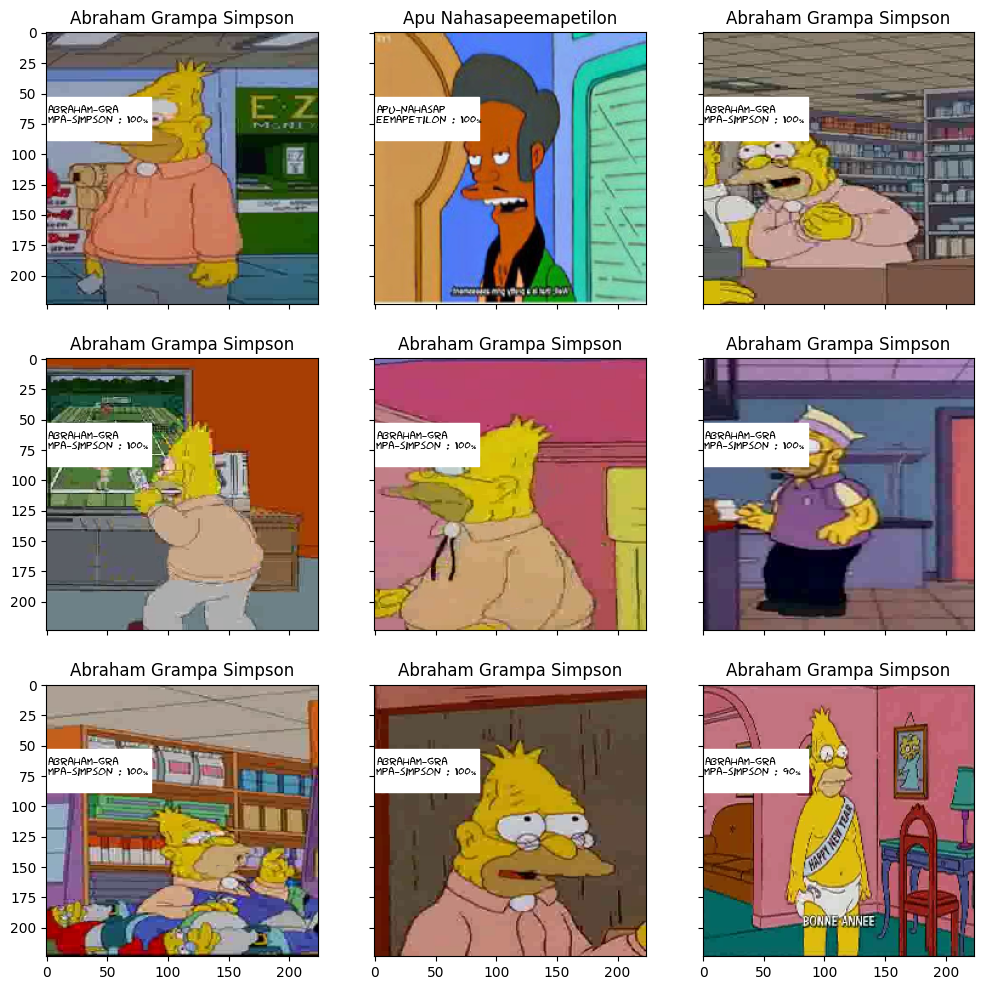

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [75]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [76]:
! ls 

gdrive	label_encoder.pkl  sample_data	test  train


In [77]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [78]:
my_submit.to_csv('gdrive/MyDrive/simpsons/simple_cnn_baseline.csv', index=False)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
